In [173]:
import numpy as np
import torch
import os

from torch import optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch.optim import SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader 
from torchvision.models import resnet

from numpy import unravel_index
import gc

from PIL import Image
from os import path
from glob import glob

import random

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from config1 import *

In [174]:
BATCH_SIZE

16

In [144]:
IMAGES_PATH="C:/Users/Sushant/CarREc/data"

In [145]:
dirs = glob(IMAGES_PATH + "/*/")
dirs = [dir.replace("\\", "/") for dir in dirs]
print(dirs)

['C:/Users/Sushant/CarREc/data/honda_accord_2015/', 'C:/Users/Sushant/CarREc/data/honda_city_2004/', 'C:/Users/Sushant/CarREc/data/honda_civic_2014/']


In [146]:
num_classes = {}

i = 0
for d in dirs:
    d = d.replace(IMAGES_PATH, "")
    d = d.replace("/", "")
    d = d.replace("\\", "")
    if " " in d:
        d = d.replace(" ", "_")
    num_classes[d] = i
    i+=1

print ("Classes: ")
print (num_classes)
print ("")

Classes: 
{'honda_accord_2015': 0, 'honda_city_2004': 1, 'honda_civic_2014': 2}



In [152]:
# read mean and dev. standard pre-computed
m = 0
s = 0
if os.path.isfile('./mean_devstd.txt'):
    m_s = open("mean_devstd.txt", "r").read()
    if "," in m_s:
        m_s = m_s.replace("\n", "")
        m_s = m_s.replace("tensor", "")
        m_s = m_s.replace("(", "")
        m_s = m_s.replace(")", "")
        m_s = m_s.split(",")
        m = torch.Tensor( [float(m_s[0]), float(m_s[1]), float(m_s[2])] )
        s = torch.Tensor( [float(m_s[3]), float(m_s[4]), float(m_s[5])] )
print(m)

tensor([4.7581, 4.7827, 4.7350])


In [153]:
def get_class(idx):
    #print (num_classes)
    for key in num_classes:
        if idx == num_classes[key]:
            return key
get_class(2)

'honda_civic_2014'

In [154]:
def pre():
    train_csv = ""
    test_csv  = ""
    train_csv_supp = []
    test_csv_supp = []
    class_files_training = []
    class_files_testing  = []

    for key in num_classes:
        if " " in key:
            os.rename(IMAGES_PATH+"/"+key, IMAGES_PATH+"/"+key.replace(" ", "_"))
            key = key.replace(" ", "_")  
            
        class_files = glob(IMAGES_PATH+"/"+str(key)+"/*")
        class_files = [w.replace(IMAGES_PATH+"/"+str(key)+"/", "") for w in class_files]
        class_files.sort()

        class_files_training = class_files[: int(len(class_files)*.73)] # get 73% class images for training
        class_files_testing = class_files[int(len(class_files)*.27)+1 :] # get 27% class images for testing

        for f in class_files_training:
            if "," in f or "#" in f or " " in f:
                tmp_f = f.replace(",", "")
                tmp_f = tmp_f.replace("#", "")
                tmp_f = tmp_f.replace(" ", "_")
                tmp_f = tmp_f.replace("\\", "/")
                os.rename(os.path.join(IMAGES_PATH, key, f), os.path.join(IMAGES_PATH, key, tmp_f))
                f = tmp_f
            train_csv_supp.append(f + ","+str(key))

        for f in class_files_testing:
            if "," in f or "#" in f or " " in f:
                tmp_f = f.replace(",", "")
                tmp_f = tmp_f.replace("#", "")
                tmp_f = tmp_f.replace(" ", "_")
                tmp_f = tmp_f.replace("\\", "/")
                os.rename(os.path.join(IMAGES_PATH, key, f), os.path.join(IMAGES_PATH, key, tmp_f))
                f = tmp_f
            test_csv_supp.append(f + ","+str(key))

    random.shuffle(train_csv_supp)
    random.shuffle(test_csv_supp)

    for t in train_csv_supp:
        train_csv += t + "\n"
    
    for t in test_csv_supp:
        test_csv += t + "\n"

    train_csv_file = open("train_file.csv", "w+")
    train_csv_file.write(train_csv)
    train_csv_file.close()

    test_csv_file = open("test_file.csv", "w+")
    test_csv_file.write(test_csv)
    test_csv_file.close()
pre()

In [155]:
def calc():
        # Algorithms to calculate mean and standard_deviation
    print("Loading dataset...")
    dataset = LocalDataset(IMAGES_PATH, TRAINING_PATH, transform=transforms.ToTensor())
    print("Calculating mean & dev std...")
    
    m = torch.zeros(3) # Mean
    s = torch.zeros(3) # Standard Deviation
    for sample in dataset:
        m += sample['image'].sum(1).sum(1)
        s += ((sample['image']-m.view(3,1,1))**2).sum(1).sum(1)
    m /= len(dataset)*256*144    
    s = torch.sqrt(s/(len(dataset)*256*144))

    print("Calculated mean and standard deviation!")
    str_m = str(m[0])+","+str(m[1])+","+str(m[2])
    str_s = str(s[0])+","+str(s[1])+","+str(s[2])
    file = open("mean_devstd.txt", "w+")
    file.write(str(str_m)+","+str(str_s))
    file.close()
calc()

Loading dataset...
Calculating mean & dev std...
Calculated mean and standard deviation!


In [156]:
class LocalDataset(Dataset):

    def __init__(self, base_path, txt_list, transform=None):
        self.base_path=base_path
        self.images = np.loadtxt(txt_list,delimiter=',',dtype='str') # use np.genfrom() instead of np.loadtxt() to skip errors

        self.transform = transform

    def __getitem__(self, index):
        f,c = self.images[index]

        image_path = path.join(self.base_path + "/" + str(c), f)
        im = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            im = self.transform(im)

        label = num_classes[c]

        return { 'image' : im, 'label':label, 'img_name': f }

    def __len__(self):
        return len(self.images)

In [157]:
num_classes

{'honda_accord_2015': 0, 'honda_city_2004': 1, 'honda_civic_2014': 2}

In [158]:
cuda_available=torch.cuda.is_available()

In [159]:
mean=m
std_dev=s

transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std_dev)])

training_set = LocalDataset(IMAGES_PATH, TRAINING_PATH, transform=transform)
validation_set = LocalDataset(IMAGES_PATH, VALIDATION_PATH, transform=transform)

training_set_loader = DataLoader(dataset=training_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
validation_set_loader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)


In [160]:
def train_model(model_name, model, lr=LEARNING_RATE, epochs=EPOCHS, momentum=MOMENTUM, weight_decay=0, train_loader=training_set_loader, test_loader=validation_set_loader):

    if not os.path.exists(RESULTS_PATH + "/" + model_name):
        os.makedirs(RESULTS_PATH + "/" + model_name)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)

    loaders = {'train':train_loader, 'test':test_loader}
    losses = {'train':[], 'test':[]}
    accuracies = {'train':[], 'test':[]}

    #testing variables
    y_testing = []
    preds = []

    if USE_CUDA and cuda_available:
        model=model.cuda()

    for e in range(epochs):
        for mode in ['train', 'test']:
            if mode=='train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0
            epoch_acc = 0
            samples = 0

            try:
                for i, batch in enumerate(loaders[mode]):
                    # convert tensor to variable
                    x=Variable(batch['image'], requires_grad=(mode=='train'))
                    y=Variable(batch['label'])

                    if USE_CUDA and cuda_available:
                        x = x.cuda()
                        y = y.cuda()

                    output = model(x)
                    l = criterion(output, y) # loss

                    if mode=='train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                    else:
                        y_testing.extend(y.data.tolist())
                        preds.extend(output.max(1)[1].tolist())
                    
                    if USE_CUDA and cuda_available:
                        acc = accuracy_score(y.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())
                    else:
                        acc = accuracy_score(y.data, output.max(1)[1])

                    epoch_loss += l.data.item()*x.shape[0] # l.data[0]
                    epoch_acc += acc*x.shape[0]
                    samples += x.shape[0]

                    print ("\r[%s] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f" % \
                        (mode, e+1, epochs, i, len(loaders[mode]), epoch_loss/samples, epoch_acc/samples))

                    if DEBUG and i == 2:
                        break
            except Exception as err:
                print ("\n\n######### ERROR #######")
                print (str(err))
                print ("\n\n######### batch #######")
                print (batch['img_name'])
                print ("\n\n")

            epoch_loss /= samples
            epoch_acc /= samples
            
            losses[mode].append(epoch_loss)
            accuracies[mode].append(epoch_acc)


            print ("\r[%s] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f" % \
                  (mode, e+1, epochs, i, len(loaders[mode]), epoch_loss, epoch_acc))
            
    torch.save(model.state_dict(), str(RESULTS_PATH) + "/" + str(model_name) + "/" + str(model_name) + ".pt")
    return model, (losses, accuracies), y_testing, preds

In [161]:
def test_model(model_name, model, test_loader = validation_set_loader):
    model.load_state_dict(torch.load(str(RESULTS_PATH) + "/" + str(model_name) + "/" + str(model_name) + ".pt"))

    if USE_CUDA and cuda_available:
        model = model.cuda()

    model.eval()

    preds = []
    gts = []

    #debug
    i = 0
    
    for batch in test_loader:
        x = Variable(batch['image'])

        if USE_CUDA and cuda_available:
            x = x.cuda()
            pred = model(x).data.cuda().cpu().numpy().copy()
        else:
            pred = model(x).data.numpy().copy()

        gt = batch['label'].numpy().copy()
        preds.append(pred)
        gts.append(gt)

        # debug
        if DEBUG:
            if i == 2:
                break
            else:
                i+=1

    return np.concatenate(preds), np.concatenate(gts)

In [162]:
def write_stats(model_name, y, predictions, gts, predictions2):
    if not os.path.exists(RESULTS_PATH + "/" + model_name):
        os.makedirs(RESULTS_PATH + "/" + model_name)

    acc = accuracy_score(gts, predictions2.argmax(1))
    cm = confusion_matrix(y, predictions)

    if DEBUG:
      score = "00 F1_SCORE 00"
    else:
      score = f1_score(y, predictions, average=None)
    
    file = open(str(RESULTS_PATH) + "/" + str(model_name) + "/" + str(model_name) + "_stats.txt", "w+")
    file.write ("Accuracy: " + str(acc) + "\n\n")
    file.write("Confusion Matrix: \n" + str(cm) + "\n\n")
    file.write("F1 Score: \n" + str(score))
    file.close()


In [166]:
def plot_logs_classification(model_name, logs):
    if not os.path.exists(RESULTS_PATH + "/" + model_name):
        os.makedirs(RESULTS_PATH + "/" + model_name)

    training_losses, training_accuracies, test_losses, test_accuracies = \
        logs[0]['train'], logs[1]['train'], logs[0]['test'], logs[1]['test']

    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.plot(training_losses)
    plt.plot(test_losses)
    plt.legend(['Training Loss','Test Losses'])
    plt.grid()
    plt.subplot(122)
    plt.plot(training_accuracies)
    plt.plot(test_accuracies)
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.grid()
    #plt.show()
    plt.savefig(str(RESULTS_PATH) + "/" + str(model_name) + "/" + str(model_name) + "_graph.png")

In [164]:
def train_model_iter(model_name, model, weight_decay=0):

    results = train_model(model_name=model_name, model=model, weight_decay=weight_decay)
    model, loss_acc, y_testing, preds = results[0], results[1], results[2], results[3]

    preds_test, gts = test_model(model_name, model=model)

    write_stats(model_name, y_testing, preds, gts, preds_test)
    plot_logs_classification(model_name, loss_acc)

gc.collect()

8365

C:\Users\Sushant\.conda\envs\my\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Sushant\.conda\envs\my\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[train] Epoch 1/10. Iteration 0/5. Loss: 0.84. Accuracy: 0.67
[train] Epoch 1/10. Iteration 1/5. Loss: 0.83. Accuracy: 0.71
[train] Epoch 1/10. Iteration 2/5. Loss: 1.11. Accuracy: 0.61
[train] Epoch 1/10. Iteration 3/5. Loss: 1.81. Accuracy: 0.60
[train] Epoch 1/10. Iteration 4/5. Loss: 1.61. Accuracy: 0.63
[train] Epoch 1/10. Iteration 4/5. Loss: 1.61. Accuracy: 0.63
[test] Epoch 1/10. Iteration 0/5. Loss: 583625408512.00. Accuracy: 0.50
[test] Epoch 1/10. Iteration 1/5. Loss: 583734263808.00. Accuracy: 0.42
[test] Epoch 1/10. Iteration 2/5. Loss: 535116950186.67. Accuracy: 0.44
[test] Epoch 1/10. Iteration 3/5. Loss: 529053384704.00. Accuracy: 0.44
[test] Epoch 1/10. Iteration 4/5. Loss: 568387174400.00. Accuracy: 0.42
[test] Epoch 1/10. Iteration 4/5. Loss: 568387174400.00. Accuracy: 0.42
[train] Epoch 2/10. Iteration 0/5. Loss: 3.40. Accuracy: 0.50
[train] Epoch 2/10. Iteration 1/5. Loss: 2.84. Accuracy: 0.54
[train] Epoch 2/10. Iteration 2/5. Loss: 2.44. Accuracy: 0.56
[train] Ep

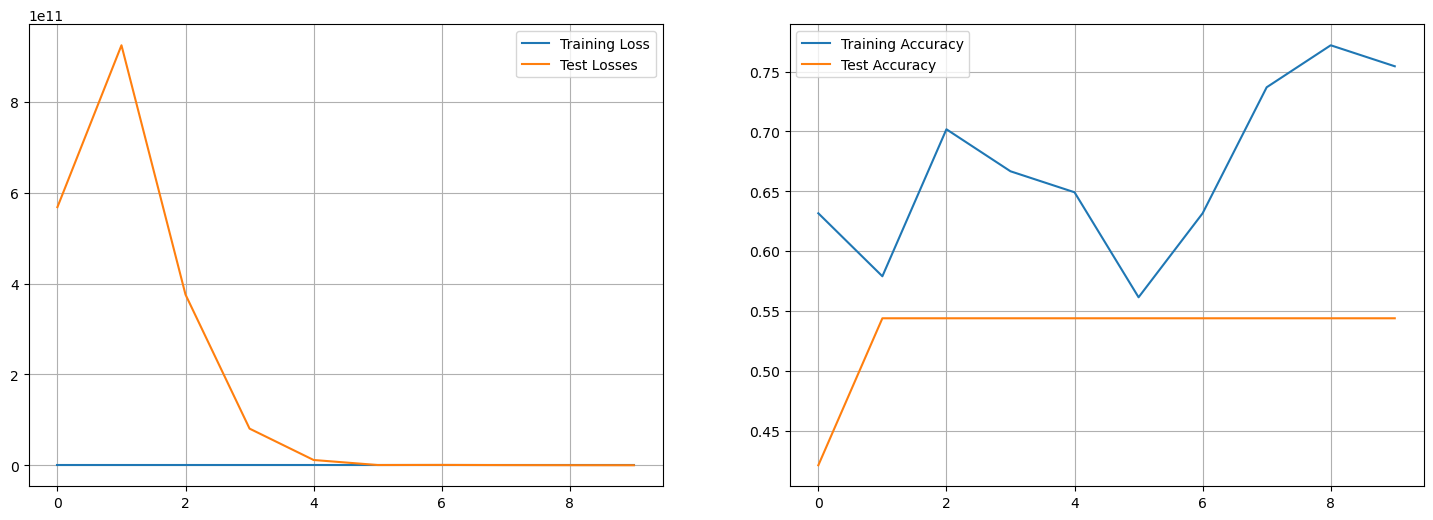

In [167]:
classes = {"num_classes": len(num_classes)}

resnet152_model = resnet.resnet152(pretrained=False, **classes)
train_model_iter("resnet152", resnet152_model)

In [168]:
model_name="resnet152"
model=resnet152_model

In [169]:
def test_sample(image_path, model=model, model_name=model_name):
    im = Image.open(image_path).convert("RGB")
    im = transform(im)

    if USE_CUDA and cuda_available:
        model = model.cuda()
    model.eval()

    x = Variable(im.unsqueeze(0))

    if USE_CUDA and cuda_available:
        x = x.cuda()
        pred = model(x).data.cuda().cpu().numpy().copy()
    else:
        pred = model(x).data.numpy().copy()

    #print (pred)

    idx_max_pred = np.argmax(pred)
    idx_classes = idx_max_pred % classes["num_classes"]
    #print(get_class(idx_classes))
    return get_class(idx_classes)

In [170]:
test_sample("C:/Users/Sushant/CarREc/data/honda_accord_2015/2015_Honda_Accord_00A0A_7cURT903w0c_600x450.jpg")

'honda_accord_2015'

In [171]:
test_sample("C:/Users/Sushant/CarREc/data/honda_civic_2014/2014_Honda_Civic_Exl_00T0T_1nmOgf2jLTm_600x450.jpg")

'honda_accord_2015'